## Load Data and Initial Grid Search

In [1]:
# Assign directory
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'

ROOT_DIR = YASH
os.chdir(ROOT_DIR + 'testing-framework/')

DATA_NAME = 'toy-agriVision-red-wavelet'
GROUP = 'layer'

# os.mkdir(DATA_NAME)
# os.mkdir(os.path.join(DATA_NAME, "CSVs"))
# os.mkdir(os.path.join(DATA_NAME, "plots"))

In [2]:
from utilities import *
from plot_utilities import *

np.random.seed(42)

In [3]:
''' Only need to run commented code once '''

data_df = pd.read_pickle(f'../transformed-data/{DATA_NAME}.pickle')
min_group, max_group = (min(data_df[GROUP])), max(data_df[GROUP]) 

group_data_map = dict()
for group in np.arange(min_group + 1, max_group + 1):
    data = np.append(data_df[(data_df['orientation'] == 'H') & (data_df[GROUP] == group)]['data'].iloc[0],
                     data_df[(data_df['orientation'] == 'V') & (data_df[GROUP] == group)]['data'].iloc[0])
    group_data_map[group] = np.sort(data)
pd.to_pickle(group_data_map, f'{DATA_NAME}/group_data_map.pickle')

group_data_map = pd.read_pickle(f'{DATA_NAME}/group_data_map.pickle')
# Consider hardcoding as per need
min_group, max_group = 2, 10
group_data_map

2016
8064
32256
100000
100000
100000
100000
100000
100000


{2: array([-4826.8984375 , -2163.046875  , -1546.71875   , ...,
         1993.37890625,  3551.38476563,  6479.35546875]),
 3: array([-3283.90625   , -3097.9765625 , -2570.9765625 , ...,
         2395.51171875,  2795.91015625,  4101.12109375]),
 4: array([-2808.28125  , -2698.5234375, -2357.3828125, ...,  1490.09375  ,
         1742.9609375,  1762.3671875]),
 5: array([-2608.765625, -1093.796875, -1077.046875, ...,  2497.28125 ,
         2507.71875 ,  2556.46875 ]),
 6: array([-2002.03125, -1203.59375, -1041.59375, ...,   601.6875 ,
          828.03125,  2308.03125]),
 7: array([-975.125 , -510.125 , -335.375 , ...,  256.3125,  288.5625,
         416.3125]),
 8: array([-204.375, -181.75 , -122.25 , ...,  121.75 ,  182.75 ,  304.625]),
 9: array([-125.75, -110.  ,  -73.75, ...,   87.5 ,   88.25,   92.25]),
 10: array([-52. , -46. , -38. , ...,  47.5,  55. ,  58.5])}

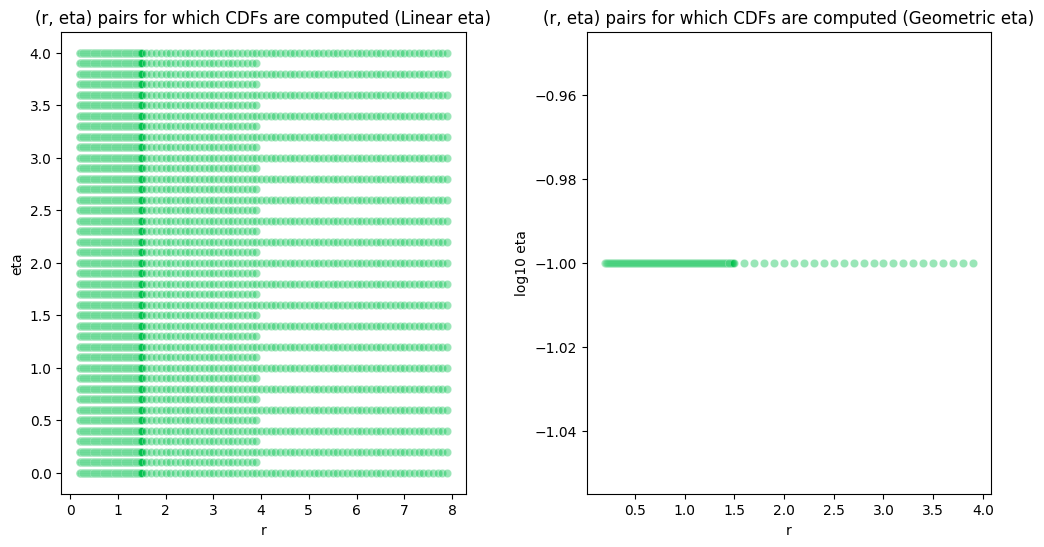

In [4]:
# Large grid search CDFs already computed (r = 0 to 8, eta = 0 to 3.9)

all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000') 
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

In [5]:
''' Only need to run commented code once'''

master_df = pd.DataFrame(columns = [GROUP, 'num_samples', 'initial_param', 'kstest_stat_initial', 'best_param_eta_0', 'kstest_stat_eta0'])
idx_eta0 = [i for i, param in enumerate(sorted(all_cdfs)) if np.isclose(param[1], 0, atol = 1e-40)]
sorted_params = sorted(all_cdfs)
for i, group in enumerate(np.arange(min_group, max_group+1)):
    print("Processing group (layer/band) ", group)
    sample = group_data_map[group]
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs)
    ksstats_eta0 = [ksstats[i] for i in idx_eta0]
    idx_min_ksstats_eta0 = idx_eta0[np.argmin(ksstats_eta0)]
    master_df.loc[i, :] = [group, sample.size, initial_param, min_stat, sorted_params[idx_min_ksstats_eta0], ksstats[idx_min_ksstats_eta0]]
master_df = master_df.set_index(GROUP)
master_df.to_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv', index_col=GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

Processing group (layer/band)  2
Processing group (layer/band)  3
Processing group (layer/band)  4
Processing group (layer/band)  5
Processing group (layer/band)  6
Processing group (layer/band)  7
Processing group (layer/band)  8
Processing group (layer/band)  9
Processing group (layer/band)  10


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0
layer,,,,,
2,2016,"(0.23, 0.0)",0.054269,"(0.23, 0)",0.054269
3,8064,"(0.28, 0.1)",0.076343,"(0.27, 0)",0.076562
4,32256,"(0.34, 0.0)",0.084420,"(0.34, 0)",0.084420
5,100000,"(0.44, 0.0)",0.101780,"(0.44, 0)",0.101780
6,100000,"(0.56, 0.2)",0.131710,"(0.79, 0)",0.131710
7,100000,"(1.32, 0.1)",0.170790,"(1.25, 0)",0.170790
8,100000,"(0.4, 0.0)",0.241590,"(0.4, 0)",0.241590
9,100000,"(0.44, 0.0)",0.298020,"(0.44, 0)",0.298020
10,100000,"(0.39, 0.0)",0.404200,"(0.39, 0)",0.404200


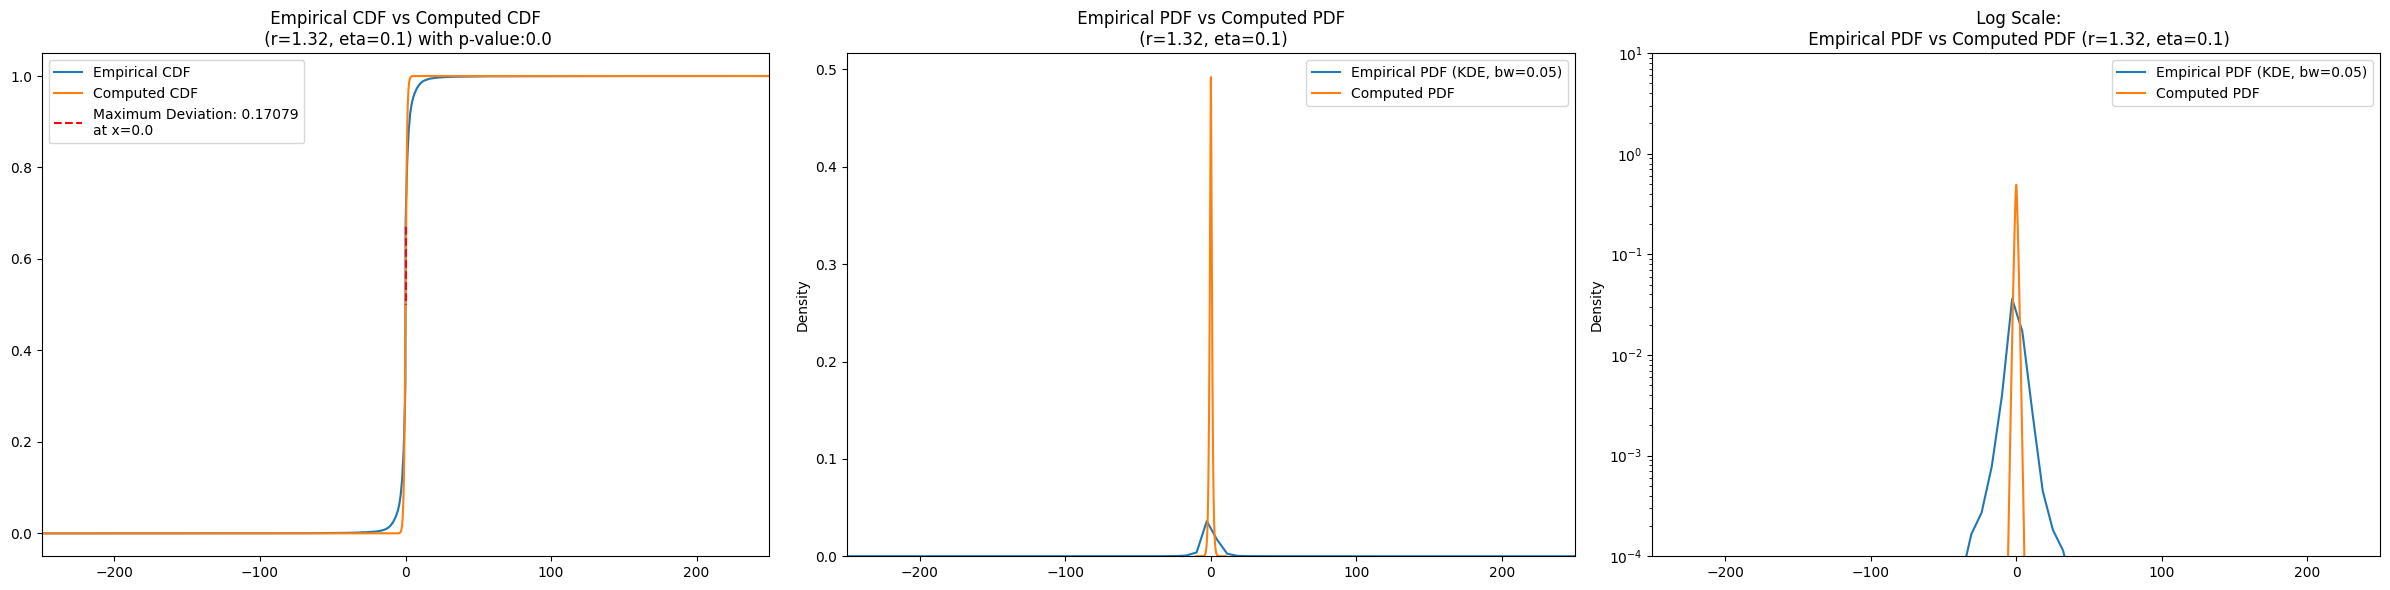

In [6]:
group = 7
visualize_cdf_pdf(group_data_map[group], 
              all_cdfs = all_cdfs, 
              params= master_df.loc[group, 'initial_param'], 
              n_samples=10000, interval = (-250, 250), 
              # provided_loc = -50
              );

In [33]:
# Given that pvalue = 0.05 and I have n samples, what should the kstest statistic be?
# Note how as num_samples increases by a factor of 4, the cutoff decreases by a factor of 2
# Could potentially include the plot in `images/loglog_pvalue_numsamples.png` 

for group in np.arange(min_group, max_group+1):
    num_points = group_data_map[group].size
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = stats.kstwo(n=num_points).isf(0.05)    
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05
band,,,,,,
2,26208,"(0.3, 1.8)",0.033574,"(0.2, 0)",0.208343,0.008383
3,44352,"(0.3, 1.5)",0.030549,"(0.2, 0)",0.237887,0.006445
4,80640,"(0.3, 1.3)",0.025860,"(0.3, 0)",0.257695,0.004780
5,100000,"(0.3, 1.1)",0.023636,"(0.3, 0)",0.231271,0.004293
6,100000,"(0.3, 1.0)",0.026717,"(0.3, 0)",0.214422,0.004293
7,100000,"(0.3, 0.8)",0.023095,"(0.3, 0)",0.188641,0.004293
8,100000,"(0.3, 0.7)",0.021231,"(0.3, 0)",0.163603,0.004293
9,100000,"(0.3, 0.5)",0.023206,"(0.3, 0)",0.138667,0.004293
10,100000,"(0.4, 2.8)",0.026919,"(0.3, 0)",0.110511,0.004293


In [37]:
r_d, eta_d = 1, 1 # Controls precision to which parameters are optimized

for group in np.arange(min_group, max_group+1): 
    sample = group_data_map[group]
    initial_param = master_df.loc[group, 'initial_param']
    master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'] = coord_descent_gengamma(sample, initial_param, r_depth = r_d, eta_depth=eta_d, layer=group)
    # If depth = 1,1 change to all_cdfs, otherwise use combine_pickles(f'{GROUP}{group}_10000')
    master_df.loc[group, 'kstest_stat_cd'] = compute_ksstat(sample, all_cdfs[(master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'])])
    print(f"{GROUP} {group} best parameters: {master_df.loc[group, 'kstest_stat_cd']}")

master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['num_samples']), axis = 1)    
master_df[['num_samples', 'initial_param', 'kstest_stat_initial', f'best_r_d{r_d}', f'best_eta_d{eta_d}', 'kstest_stat_cd', 'n_pval_0.05']].to_csv(f'{DATA_NAME}/CSVs/optimized_params.csv')
master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

band 2 best parameters: 0.033573920417782954
band 3 best parameters: 0.03054925902387473
band 4 best parameters: 0.025860462889728653
band 5 best parameters: 0.023635615165637724
band 6 best parameters: 0.026717333010849442
band 7 best parameters: 0.023094963727216866
band 8 best parameters: 0.021230882377323734
band 9 best parameters: 0.023206389762905455
band 10 best parameters: 0.02691944982237615
band 11 best parameters: 0.02723638140709775
band 12 best parameters: 0.025200977645778222
band 13 best parameters: 0.021964737736628326
band 14 best parameters: 0.018907243142877436


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,best_r_d1,best_eta_d1,kstest_stat_cd,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,
2,26208,"(0.3, 1.8)",0.033574,"(0.2, 0)",0.208343,0.008383,50.0,0.437836,0.0,50.0,0.420682,0.0,50.0,0.402162,0.0,0.3,1.8,0.033574,1638
3,44352,"(0.3, 1.5)",0.030549,"(0.2, 0)",0.237887,0.006445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,1.5,0.030549,2079
4,80640,"(0.3, 1.3)",0.025860,"(0.3, 0)",0.257695,0.004780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,1.3,0.025860,2835
5,100000,"(0.3, 1.1)",0.023636,"(0.3, 0)",0.231271,0.004293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,1.1,0.023636,3125
6,100000,"(0.3, 1.0)",0.026717,"(0.3, 0)",0.214422,0.004293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,1.0,0.026717,2635
7,100000,"(0.3, 0.8)",0.023095,"(0.3, 0)",0.188641,0.004293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,0.8,0.023095,3514
8,100000,"(0.3, 0.7)",0.021231,"(0.3, 0)",0.163603,0.004293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,0.7,0.021231,3952
9,100000,"(0.3, 0.5)",0.023206,"(0.3, 0)",0.138667,0.004293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3,0.5,0.023206,3514
10,100000,"(0.4, 2.8)",0.026919,"(0.3, 0)",0.110511,0.004293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,2.8,0.026919,2635


## Comparing Empirical and Computed CDF/PDF

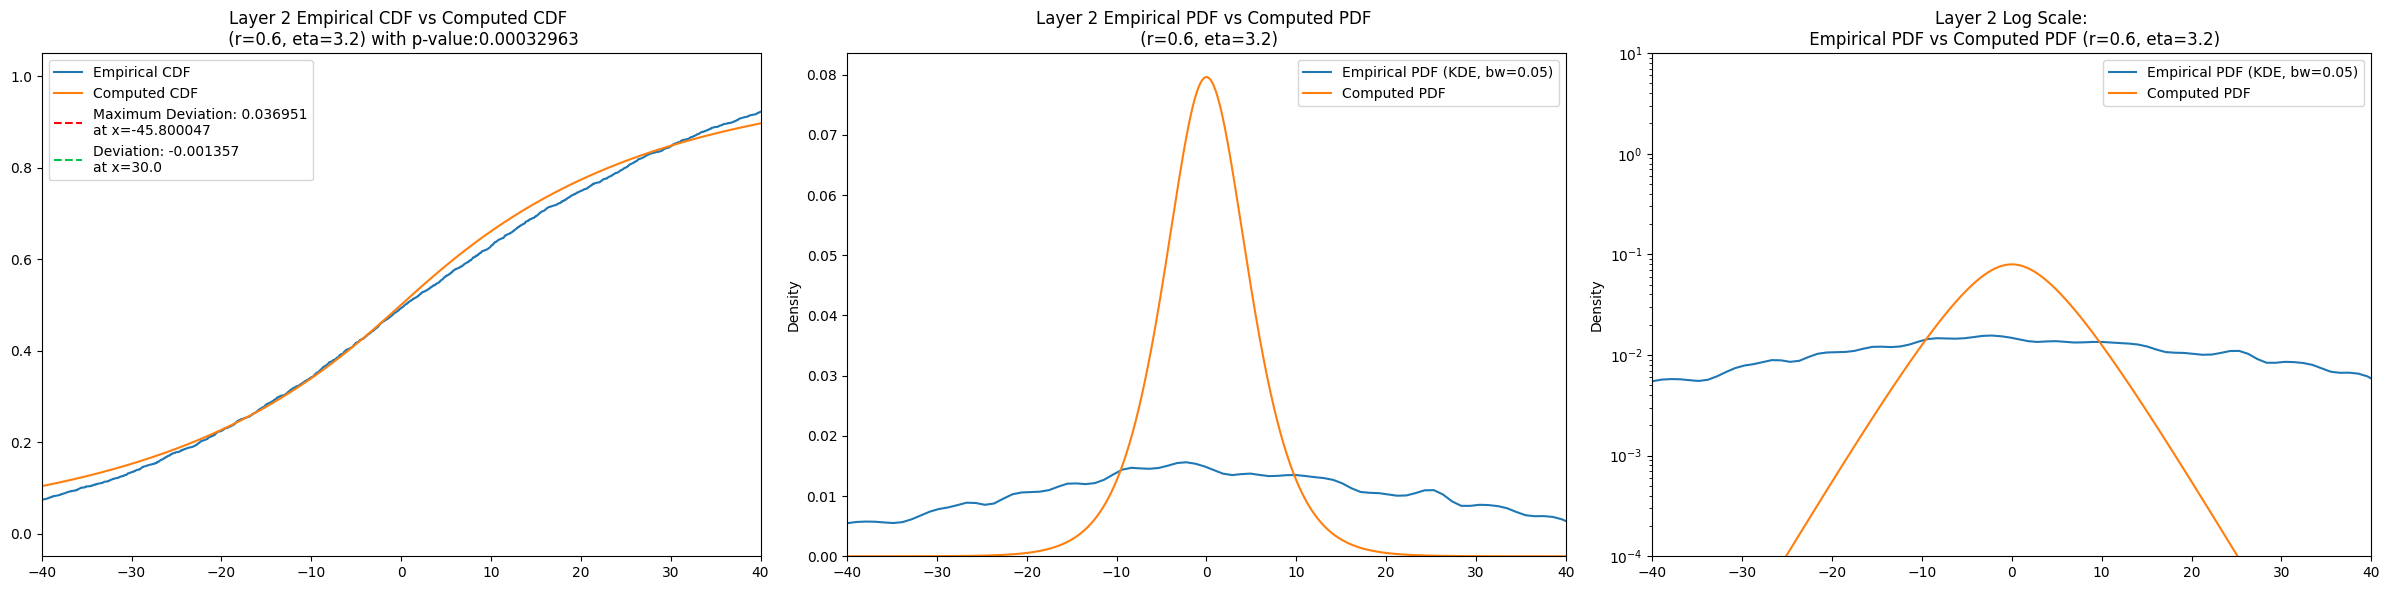

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:87: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


KeyboardInterrupt: 

In [15]:
for group in np.arange(min_group, max_group+1):
    group_info = master_df.loc[group]
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (group_info[f'best_r_d{r_d}'], group_info[f'best_eta_d{eta_d}']), 
                    log_scale = True,
                    all_cdfs = combine_pickles(f'{GROUP}{group}_10000'),
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(f'{DATA_NAME}/plots/compare_cdf_pdf_layer_{group}.png', bbox_inches = 'tight')

## Comparing with Gaussian and Laplace

In [38]:
def coord_descent_scipy(sample, initial_param):
    '''
    '''
    r_0, eta_0 = initial_param
    find_r_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_0), method = 'bounded', bounds = (max(0.5, r_0-0.1), r_0+0.1))
    r_1 = find_r_1['x']
    find_eta_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_eta', r_1), method = 'bounded', bounds = (max(0, eta_0-0.1), eta_0+0.1))
    eta_1 = find_eta_1['x']
    find_r_2 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_1), method = 'bounded', bounds = (max(0.5, r_1-0.1), r_1+0.1))

    r_2 = find_r_2['x']

    return r_2, eta_1, find_r_2['fun']

for layer in np.arange(min_group, max_group+1):
    master_df.loc[layer, f'best_r_scipy'], master_df.loc[layer, f'best_eta_scipy'], master_df.loc[layer, f'kstest_stat_cd_scipy'] = coord_descent_scipy(group_data_map[layer], master_df.loc[layer, 'initial_param'])

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv', index_col = 'layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df


ValueError: The lower bound exceeds the upper bound.

In [48]:
for group in np.arange(min_group, max_group+1):
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), bounds = (0, 10000))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), bounds = (0, 10000))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), bounds = (0, 10000))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_cd'])) #, master_df.loc[group, 'kstest_stat_cd_scipy'])), 6)

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in divide
  return bound(*args, **kwds)


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,kstest_stat_cutoff_0.05,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,best_r_d1,best_eta_d1,kstest_stat_cd,n_pval_0.05,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,
2,26208,"(0.3, 1.8)",0.033574,"(0.2, 0)",0.208343,0.008383,3348.7400,0.064491,3.302950e-95,2803.5700,0.041498,1.181580e-39,2240.4200,0.044518,1.424880e-45,0.3,1.8,0.033574,1638,4.220400e-26
3,44352,"(0.3, 1.5)",0.030549,"(0.2, 0)",0.237887,0.006445,2378.8800,0.061789,1.199890e-147,1957.1200,0.040640,4.363620e-64,1552.3100,0.043292,1.138890e-72,0.3,1.5,0.030549,2079,2.149900e-36
4,80640,"(0.3, 1.3)",0.025860,"(0.3, 0)",0.257695,0.004780,1829.6600,0.058881,1.819770e-243,1514.2100,0.037037,1.515300e-96,1208.5500,0.040028,1.059500e-112,0.3,1.3,0.025860,2835,2.782900e-47
5,100000,"(0.3, 1.1)",0.023636,"(0.3, 0)",0.231271,0.004293,1371.0900,0.057286,1.089440e-285,1129.7100,0.036042,2.661030e-113,901.5550,0.038980,1.844190e-132,0.3,1.1,0.023636,3125,5.823900e-49
6,100000,"(0.3, 1.0)",0.026717,"(0.3, 0)",0.214422,0.004293,1102.1500,0.059431,NaN,903.0090,0.038646,3.342970e-130,719.3220,0.041734,8.790770e-152,0.3,1.0,0.026717,2635,1.915700e-62
7,100000,"(0.3, 0.8)",0.023095,"(0.3, 0)",0.188641,0.004293,869.7160,0.058952,1.541800e-302,715.3380,0.037801,1.374670e-124,565.5790,0.040767,7.569380e-145,0.3,0.8,0.023095,3514,9.128200e-47
8,100000,"(0.3, 0.7)",0.021231,"(0.3, 0)",0.163603,0.004293,687.5390,0.056573,1.244300e-278,567.6060,0.035025,5.110440e-107,445.4180,0.037514,1.038220e-122,0.3,0.7,0.021231,3952,1.378400e-39
9,100000,"(0.3, 0.5)",0.023206,"(0.3, 0)",0.138667,0.004293,528.7160,0.054433,5.695290e-258,434.7960,0.033399,2.366620e-97,346.4120,0.036423,1.066500e-115,0.3,0.5,0.023206,3514,3.251800e-47
10,100000,"(0.4, 2.8)",0.026919,"(0.3, 0)",0.110511,0.004293,409.2520,0.052898,1.230660e-243,337.5150,0.031420,3.335290e-86,270.5520,0.034892,3.258300e-106,0.4,2.8,0.026919,2635,2.189500e-63


# Examining Tail Behavior

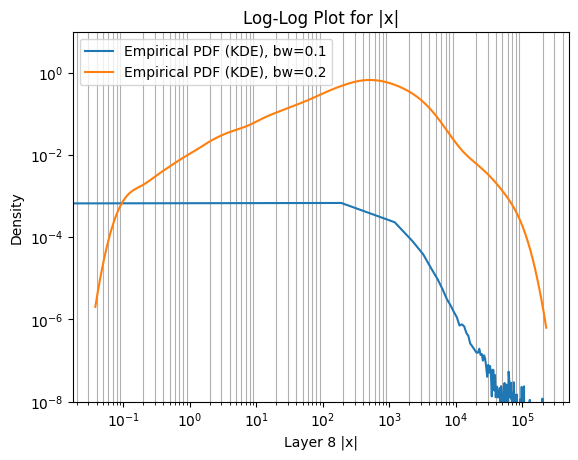

In [55]:
bw = 0.1
group = 7
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_7.png', bbox_inches = 'tight')

bw = 0.2
group = 8
x = np.abs(group_data_map[group])
fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
fig.set_xscale('log')
fig.set_yscale('log')
fig.set_ylim(bottom = 10**-8, top=10)
plt.xlabel(f'Layer {group} |x|')
plt.title(f'Log-Log Plot for |x|')
plt.grid(True, 'minor')
plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_8.png', bbox_inches = 'tight')

plt.legend()

In [ ]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[master_df.loc[layer, 'initial_param']]
            elif distro == 'gaussian':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for layer in np.arange(min_group, max_group+1):
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))


master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df.csv', index_col = 'layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta_0,kstest_stat_cutoff_0.05,best_r_d3,best_eta_d2,kstest_stat_cd,n_pval_0.05,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.6, 3.2)",0.038340,"(0.4, 0)",0.102709,0.024030,0.602,3.20,0.036033,1341,...,"(0.023188, 1.0344)","(0.023188, 1.0344)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.038340,3.834015e-02
3,12720,"(0.7, 3.5)",0.020230,"(0.4, 0)",0.106739,0.012029,0.705,3.60,0.019689,4770,...,"(0.026952, 1.0742)","(0.026952, 1.0706)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.020230,1.802446e-02
4,50880,"(0.8, 3.0)",0.011666,"(0.5, 0)",0.061078,0.006018,0.803,3.00,0.010263,16098,...,"(0.035397, 1.0105)","(0.035397, 1.0089)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.011666,1.166561e-02
5,203520,"(0.9, 1.6)",0.003225,"(0.6, 0)",0.040301,0.003010,0.901,1.60,0.003025,203520,...,"(0.17436, 5225.2)","(0.17436, 5225.2)","(0.90723, 9.236e+34)","(0.98075, 9.236e+34)","(0.95007, 9.254e+46)","(0.97884, 9.254e+46)","(0.0034259, 1.0662)","(0.0034259, 1.0104)",0.003225,3.224737e-03
6,814080,"(1.1, 0.5)",0.006844,"(0.9, 0)",0.014370,0.001505,1.030,0.33,0.003651,128142,...,"(0.70499, 73248.0)","(0.70499, 73248.0)","(0.87957, 3.725e+56)","(0.99905, 3.725e+56)","(0.93638, 2.5142e+75)","(0.99905, 2.5142e+75)","(0.0013751, 1.2182)","(0.0013751, 1.0041)",0.002969,2.612471e-04
7,3256320,"(4.6, 0.0)",0.024895,"(4.6, 0)",0.024895,0.000753,4.630,0.00,0.024877,3016,...,"(0.92184, 1911800000.0)","(0.99998, 83877.0)","(0.85009, 2.0712000000000005e+268)","(0.99998, 2.0712000000000005e+268)","(0.90639, inf)","(0.99998, inf)","(0.0015714, 1.506)","(0.0015714, 1.0007)",0.018187,2.426023e-05
8,13025280,"(5.7, 0.0)",0.171259,"(5.7, 0)",0.171259,0.000376,5.700,0.00,0.171259,60,...,"(0.19852, 41045000.0)","(1.0, 3823.9)","(0.83652, inf)","(1.0, inf)","(0.89531, inf)","(1.0, inf)","(0.0028504, 1.7139)","(0.0028504, 1.0001)",0.004163,7.676389e-07


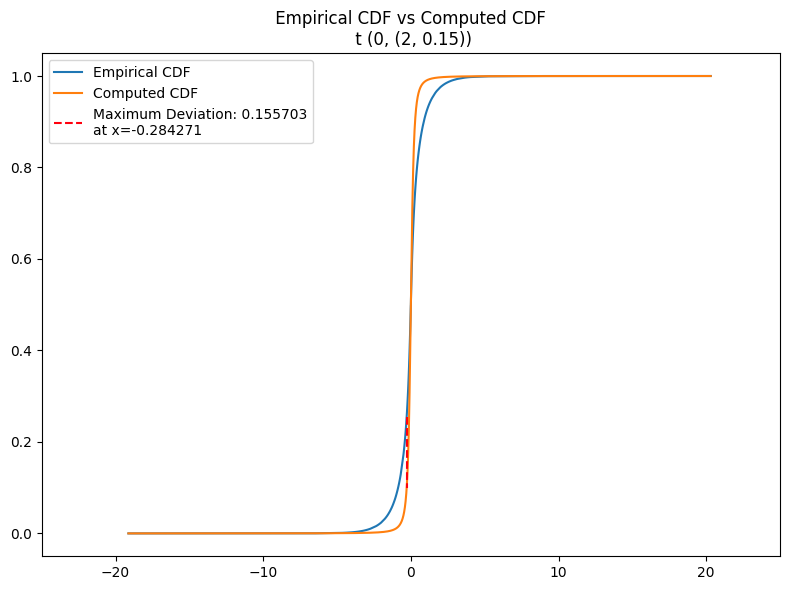

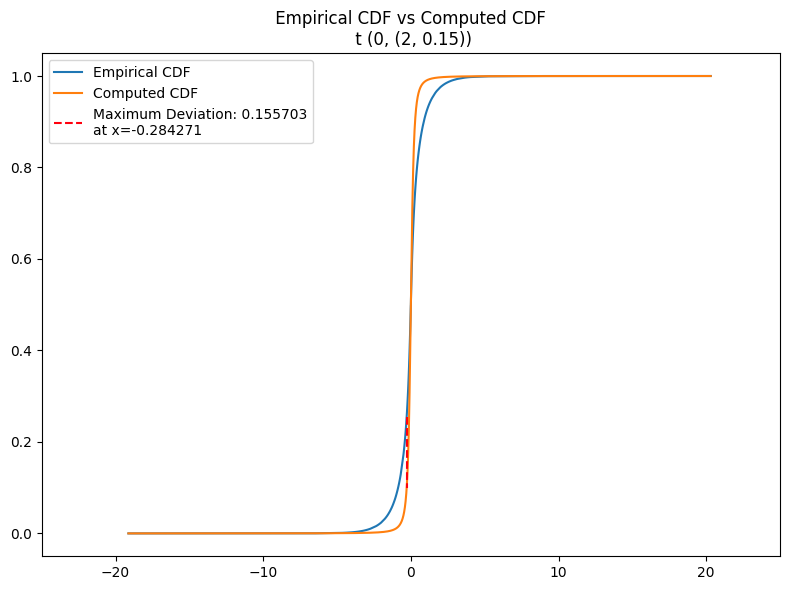

In [19]:
visualize_cdf(group_data_map[7], params=(2, 0.15), distro='t')

In [53]:
#master_df.filter(regex='num_samples|kstest_stat.*')
# master_df.filter(regex='num_samples|best.*')
# master_df.filter(regex='.*gaussian')
master_df.filter(regex='kstest_stat.*')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,kstest_stat_initial,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_cd
band,,,,,,,
2,0.033574,0.208343,0.008383,0.064491,0.041498,0.044518,0.033574
3,0.030549,0.237887,0.006445,0.061789,0.040640,0.043292,0.030549
4,0.025860,0.257695,0.004780,0.058881,0.037037,0.040028,0.025860
5,0.023636,0.231271,0.004293,0.057286,0.036042,0.038980,0.023636
6,0.026717,0.214422,0.004293,0.059431,0.038646,0.041734,0.026717
7,0.023095,0.188641,0.004293,0.058952,0.037801,0.040767,0.023095
8,0.021231,0.163603,0.004293,0.056573,0.035025,0.037514,0.021231
9,0.023206,0.138667,0.004293,0.054433,0.033399,0.036423,0.023206
10,0.026919,0.110511,0.004293,0.052898,0.031420,0.034892,0.026919


In [1]:
visualize_cdf(obs_x_dict[7], params=0.15, distro='t')

NameError: name 'visualize_cdf' is not defined